### n-step SARSA with neural network function approximation to solve the Maze problem.


In [1]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class


In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = np.array([[0, -1], [0, 1], [-1, 0], [1, 0]])
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        #print(self._s ,"ggg" ,self._actions[a],"in next")
        curr = self.check_state(s1)
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [5]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [6]:
tf.reset_default_graph()

In [7]:
# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,63],dtype=tf.float32)
action_in = tf.placeholder(shape=(), dtype=tf.int32)
action_out = tf.placeholder(shape=(), dtype=tf.int32)

W = tf.get_variable("W", shape=[63, 4],
           initializer=tf.contrib.layers.xavier_initializer())

Qout = tf.matmul(inputs1,W)

predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)

loss = tf.reduce_sum(tf.square(nextQ[0, action_out]- Qout[0, action_in]))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.07)
updateModel = trainer.minimize(loss)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
def encoding(state):
    one_hot = np.zeros((9 * 7))
    # row * i + j
    one_hot[9 * state[0] + state[1]] = 1
    return one_hot.reshape(-1,1).T

In [11]:
def train_n(n):
    init = tf.initialize_all_variables()
    fig = plt.figure(figsize=(16, 16))
    # Set learning parameters
    epsilon = 1.0
    num_episodes = 1000
    steps = 400
    gamma = 0.99
    alpha = 0.07

    final_epsilon = 0.1
    epsilon_decay =  np.exp(np.log(final_epsilon) / num_episodes)
    #create lists to contain total rewards and steps per episode
    jList = []
    rList = []
    etrace = []
    rtrace = []
    start = [0,0]

    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_episodes):
            
            rewards = []
            states = []
            actions = []
            
            T = np.inf
            
            env.init(start)
            s = env.get_cur_state()
            states.append(s)
            
            a, Q = sess.run([predict,Qout],feed_dict={inputs1:encoding(s)})
            if np.random.rand(1) < epsilon:
                action = np.random.randint(4)
            else:
                action = a[0]
            actions.append(action)
            rewards.append(0)
            rAll = 0

            for step in range(steps):
                
                if step < T:
                    r1 = env.next(action)
                    rewards.append(r1)
                    
                    s1 = env.get_cur_state()
                    states.append(s1)
                    
                    if env.is_goal():
                        T = step+1
                    else:
                        a1, Q1 = sess.run([predict,Qout],feed_dict={inputs1:encoding(s1)})
                        if np.random.rand(1) < epsilon:
                            action1 = np.random.randint(4)
                        else:
                            action1 = a1[0]
                        actions.append(action1)    
                        
                tau = step - n + 1
                if tau >= 0:
                    G = 0
                    for k in range(tau+1, min(tau + n + 1, T + 1)):
                        #print(k)
                        G += gamma**(k-tau-1) * rewards[k]
                        
                    #G = np.ones((1, 4)) * G
                    if tau+n < T:
                        Q_n = sess.run(Qout, feed_dict={inputs1:encoding(states[tau + n])})
                        G += gamma**n + Q_n

                        _,W1 = sess.run([updateModel,W],feed_dict={inputs1:encoding(s),nextQ:G, action_in: actions[tau], action_out: actions[-1]})
                if tau == T-1:
                    break
                    
             
                s = s1
                action = action1

            epsilon *= epsilon_decay
            etrace.append(epsilon)
            rtrace.append(np.sum(rewards))
            
            jList.append(step)
            rList.append(rAll)
            
            last_plot = (i == num_episodes-1)
    
            if i % 10 == 0 or last_plot:
                plt.clf()
                fig.add_subplot(221)
                plt.plot(rtrace, "b-")
                plt.ylabel("sum of rewards")

                fig.add_subplot(222)
                plt.plot(etrace, "-")
                plt.ylabel("p(random action), $\epsilon$")


                plt.suptitle(''.join(["Episode ",str(i)]))
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.draw()

                ipd.clear_output(wait=True)
                ipd.display(fig)
            ipd.clear_output(wait=True)
    #print( "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


### Analysis for different values of n i.e n= {1, 4, 8}

### For n =1

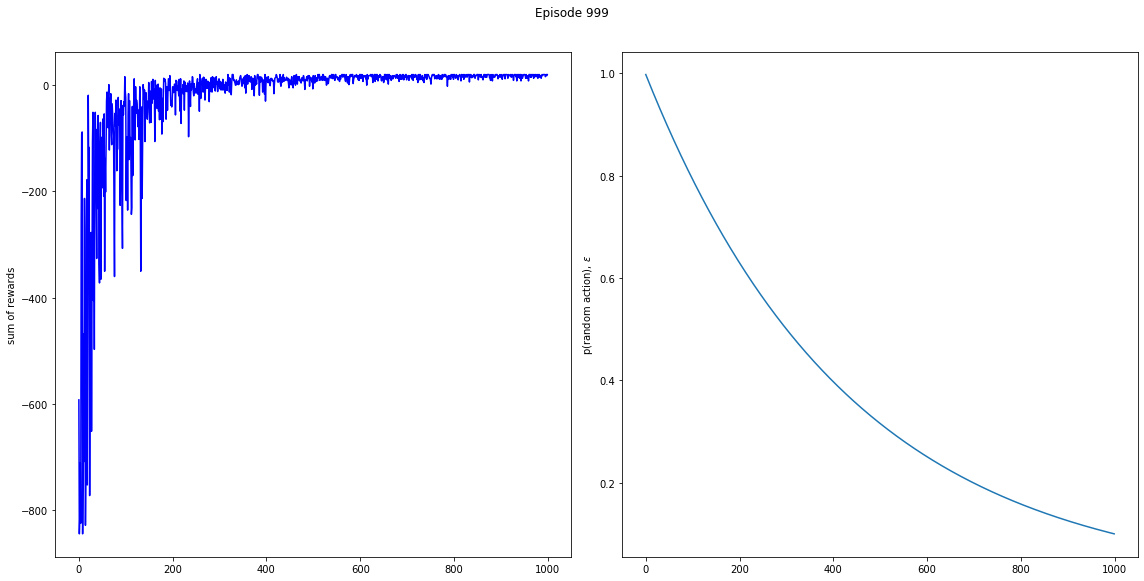

In [12]:
train_n(1)

### For n = 4

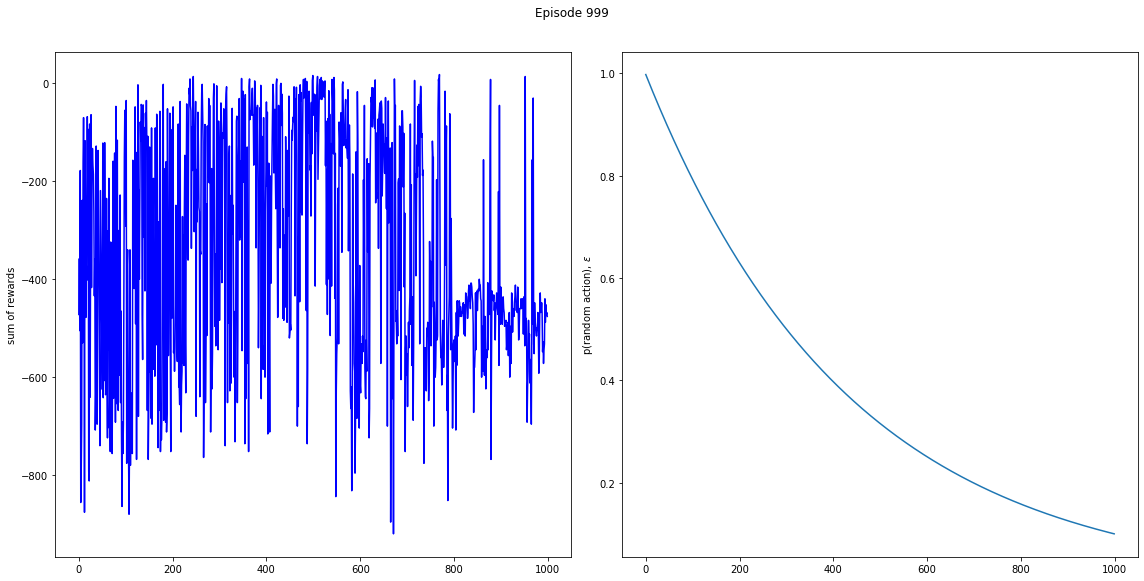

In [13]:
train_n(4)

### For n = 8

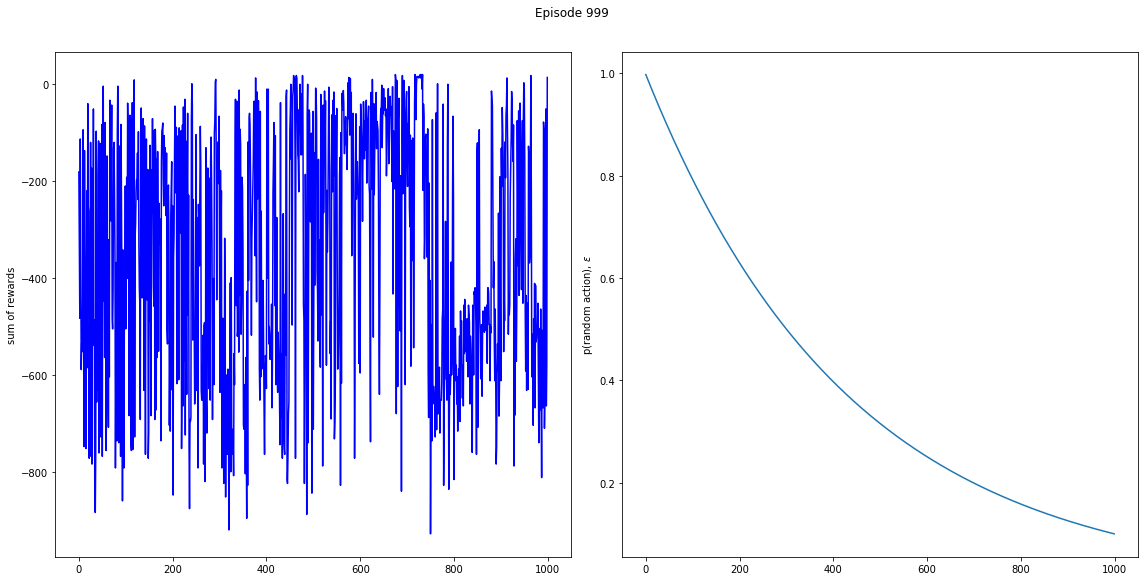

In [21]:
train_n(8)